# Automated click audio labeling for audio files without additional noise


In [27]:
# all libraries used in this notebook

import os.path
from pathlib import Path
import re
import librosa
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

Important: this nootbook is for atomated labeling of audio files, where click events can be detected based on maximal amplitude values

For connector types: Ethernet and Kombination 2. Kombination 1 hase two click events, resilting in longer window size for detection.

### Directory structure
Audio file dataset folders are in the subfolder "01_audioDatasets/..." <br>
("01_audioDatasets" folder is excluded from git, the relative path to this folder is in the gitignore file)<br>

In case of new dataset --> new folder in "01_Data/01_audioDatasets/"

```
01_Electrical_Connector_Click-Event_Detection_git_repo/
└─── 01_Data/
    └─── 01_audioDatasets/ (excluded from git)
        ├─── 01_ethernet_without_additional_noise
        ├─── 02_ethernet_with_additional_noise
        ├─── ...
        ├─── 07_noise_samples
        ├─── [New dataset folders go here]
    └─── clickDatasetPreprocessing.ipynb (current notebook)
└─── ...
```

In [42]:
# import utilities

cwd = str(Path.cwd()) # current working directory, should be the path to 01_Dataset, in which this notebook is located
parent_dir = str(Path(cwd).parent) # get project directory
utilities_dir_full_pat = os.path.join(parent_dir, "05_Utilities")

# import moduls from utilities
sys.path.append(utilities_dir_full_pat)
from getMelSpectrogram import getMelSpectrogram
from plotSpectrogram import spectrogramPlotter

# initialize classes
getMelSpectrogram = getMelSpectrogram()
spectrogramPlotter = spectrogramPlotter()

## 1. Read in audio files, process audio data, and generate mel-scaled spectrograms

In [29]:
# sorting function by numbers in the name for files

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [30]:
# list all audio file datasets in folder "01_Data/01_audioDatasets"

audio_datasets_main_dir_name = "01_audioDatasets"
audio_datasets_main_dir = os.path.join(cwd, audio_datasets_main_dir_name)
audio_datasets = []

if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets) # sort the list of audio datasets
else:
    print("\"01_audioDatasets\" directory does not exist or is not in the correct location.")

print(audio_datasets)

['01_ethernet_without_additional_noise', '02_ethernet_with_additional_noise', '03_kombination_1_without_additional_noise', '04_kombination_1_with_additional_noise', '05_kombination_2_without_additional_noise', '06_kombination_2_with_additional_noise', '07_noise_samples', 'voice_memo_loc_mac.txt']


In [31]:
# select dataset (datasets recorded without additional noise)

dataset_num = 0
print("Selected dataset: ", audio_datasets[dataset_num])

Selected dataset:  01_ethernet_without_additional_noise


In [32]:
# add audio files from selected dataset to a list

audio_dataset_dir = os.path.join(cwd, audio_datasets_main_dir_name) + "/" + audio_datasets[dataset_num]
audio_files = [f for f in os.listdir(audio_dataset_dir) if f.endswith('.m4a')]
audio_files_sorted = sorted(audio_files, key=sort_key_func)
print(f"Dataset length: {len(audio_files_sorted)}")
i = 0
print("First 5 files in the selected dataset:")
while i < 5:
    print(audio_files_sorted[i])
    i += 1


Dataset length: 60
First 5 files in the selected dataset:
ethernet_1.m4a
ethernet_2.m4a
ethernet_3.m4a
ethernet_4.m4a
ethernet_5.m4a


In [33]:
# constant values used in real-time detection as well

# original sampling rate of the microphone is 48 kHz, the frequency response from the microphone specifications is 20 Hz to 20 kHz which indicates a max sampling rate of 40 kHz (Nyquist theorem)
# however, for a sampling rate of 40 kHz, a darker zone can be seen on the top of the spectrogram meaming the microphone cannot capture frequencies above a certain limit
# thus, the sampling rate is set to 32 kHz to avoid this issue, at this sampling rate there is no dark zone on the top of the spectrogram
sampling_rate = 32000

chunk_size = 4096 # number of samples in one chunk of audio data
spectrogram_columns_per_chunk = 8 # number of spectrogram columns in one chunk of audio data

resolution = (chunk_size/sampling_rate)/spectrogram_columns_per_chunk # 0.016 seconds when processing a chunk of 4096 samples at a sampling rate of 32 kHz with 8 spectrogram columns per chunk

hop_length = int(resolution * sampling_rate) # the number of samples between successive frames in the STFT
n_mels = 128 # number of mel bands (rows in the mel-scaled spectrogram), 128 is a common value

f_min = 20 # minimum frequency in Hz, from the microphone specification
f_max = 14000 # maximum frequency in Hz, the microphone has a max frequency response of 20 kHz, however, the sampling rate is 32 kHz, so the max frequency can be 16 kHz or lower

In [34]:
# get information about the range of values in the mel-spectrogram
# these infromation is used for the dB conversion

max_amplitude_squere_mel = 0
min_amplitude_squere_mel = None

for i in range(len(audio_files_sorted)):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
    signal, time, D_mel, D_mel_dB = getMelSpectrogram.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min = None, dB_ref = None)
    max_amplitude_squere_mel = D_mel.max() if D_mel.max() > max_amplitude_squere_mel else max_amplitude_squere_mel
    if i == 0:
        min_amplitude_squere_mel = max_amplitude_squere_mel
    else:
        min_amplitude_squere_mel = D_mel.min() if D_mel.min() < min_amplitude_squere_mel else min_amplitude_squere_mel

print(f"Min amplitude squere in the mel-spectrograms: {min_amplitude_squere_mel}, Max amplitude squere in the mel-spectrograms: {max_amplitude_squere_mel}")

Min amplitude squere in the mel-spectrograms: 1.6248338937339957e-13, Max amplitude squere in the mel-spectrograms: 243.71078491210938


In [35]:
# constant values used in real-time detection as well

# dB_ref and a_squere_min is choosen based on the min and max values of amplitude squere in the dataset

dB_ref = 1e3 # reference value for dB conversion
a_squere_min = 1e-12 # larger than 0 to avoid log(0)
top_dB_abs = abs(10*np.log10(a_squere_min)) # maximum dB value -> 10*log(a_squere_min) = -120
top_dB_abs

120.0

In [36]:
# plot the mel-spectrogram

def plot_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate):

    fig_x = 16
    fig_y = 6
    fig, axs = plt.subplots(2, 1, figsize=(fig_x, fig_y))

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(time, signal)
    ax1.set_xlim(left=0, right=time[-1])
    #ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Amplitude')
    ax1.set_xlim(left=time[0], right=time[-1])

    ax2 = plt.subplot(2, 1, 2)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Frequency [Hz]')
    #ax2.set_yscale('log')
    #ax2.set_xlim(left=time[0], right=time[-1])
    ax2.axes.xaxis.set_ticklabels([]) 
    mel_spec_img = ax2.pcolormesh(np.linspace(0, signal.shape[0] / sampling_rate, D_mel_dB.shape[1]),
                                            np.linspace(f_min, f_max, n_mels), 
                                            D_mel_dB, shading='auto', cmap='inferno')

    #mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=dB_ref)
    mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=0)

    cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.02])
    fig.colorbar(mel_spec_img, cax=cbar_ax, orientation='horizontal', format="%+2.0f dB")

    plt.show()


In [43]:
# plot the wave and mel spectrogram of an audio file from the selected dataset

file_id_num = 0 # selected file ID number

if file_id_num < len(audio_files_sorted):
    audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[file_id_num])
    signal, time, D_mel, D_mel_dB = getMelSpectrogram.get_mel_spectrogram(audio_file_path, sampling_rate, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
    spectrogramPlotter.plot_single_wave_and_mel_spectrogram(signal, time, D_mel_dB, top_dB_abs, f_min, f_max, n_mels, sampling_rate)
else:
    print("File ID out of range")

TypeError: spectrogramPlotter.plot_single_wave_and_mel_spectrogram() takes 8 positional arguments but 9 were given

## 2. Automated labeling - find click peaks in the wave files
Note: This works only for files where click peak can be easily detected, i.e. no other noise with higher amplitude is present in the wavefrom

In [34]:
def plot_signal_interval(signal, time, peak_time, interval):
    
    plt.figure(figsize=(16, 6))
    plt.plot(time, signal)
    plt.xlim(peak_time-interval, peak_time+interval)
    
    if peak_time is not None:
        plt.axvline(x=peak_time, color='r', linestyle='--', label='Click Peak')
        plt.legend()

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Audio Signal with Click Event Peak")
    plt.tight_layout()
    plt.show()

In [35]:
# calculating peak times for each audio file in the selected dataset based on the maximum absolute value of the signal amplitude

time_interval = (chunk_size/sampling_rate) * 4 # this will be the window size in the real time detection as well --> 4 chunks with 4096 samples each --> with the 32 kHz sampling rate this is 0.512 seconds

# calculate peak time of the click event for each audio file in the selected dataset
def calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, n_fft, hop_length, n_mels, dB_ref):
    signals = []
    signal_times = []
    peak_indices = []
    peak_times = []
    spectrograms = []

    for i in range(len(audio_files_sorted)):
        audio_file_path = os.path.join(audio_dataset_dir, audio_files_sorted[i])
        signal, time, D_mel, D_mel_dB = get_mel_spectrogram(audio_file_path, sampling_rate, n_fft, hop_length, n_mels, f_min, f_max, a_squere_min, dB_ref)
        signals.append(signal)
        signal_times.append(time)
        spectrograms.append(D_mel_dB)

        # search abs max value of the signal within the search interval

        search_interval_min = 5 # define search intervall based on the later plot for peak times
        search_interval_min_index = search_interval_min * sampling_rate
        search_interval_max_index = len(signal)

        j = search_interval_min_index
        peak_index = j
        while j < search_interval_max_index-1:
            if signal[j+1] > signal[peak_index]:
                peak_index = j+1
            j = j + 1
    
        #peak_index = np.argmax(np.abs(signal))
        
        peak_time = peak_index / sampling_rate
        peak_times.append(peak_time)

    return signals, signal_times, peak_indices, peak_times, spectrograms 

# get the signals, signal times and peak times for the selected dataset
signals, signal_times, peak_indices, peak_times, spectrograms  = calc_peak_times(audio_files_sorted, audio_dataset_dir, sampling_rate, n_fft, hop_length, n_mels, dB_ref)


/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_45454/2085235337.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sampling_rate = librosa.load(audio_file_path, sr=sampling_rate)
/opt/anaconda3/envs/clickSense/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


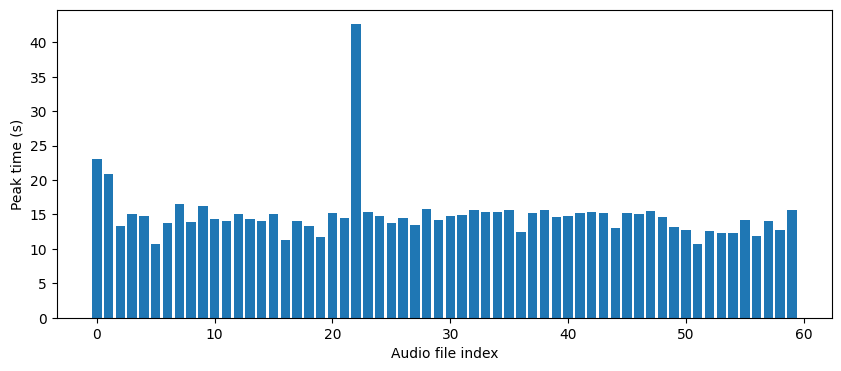

Mean of the peak times in the peg-in-hole process: 14.927367187500003


In [36]:
# check if the peak time are around the same time for all audio files -> same robotic peg-in-hole event was recorded with nearly the same start and stop times
# outliers should be checked

plt.figure(figsize=(10, 4))
plt.bar(range(len(peak_times)), peak_times)
plt.xlabel('Audio file index')
plt.ylabel('Peak time (s)')

plt.show()

print(f"Mean of the peak times in the peg-in-hole process: {np.mean(peak_times)}")

/var/folders/bj/7ggffpq918g65k1n35l6t6t40000gn/T/ipykernel_45454/2088481195.py:5: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(peak_time-interval, peak_time+interval)


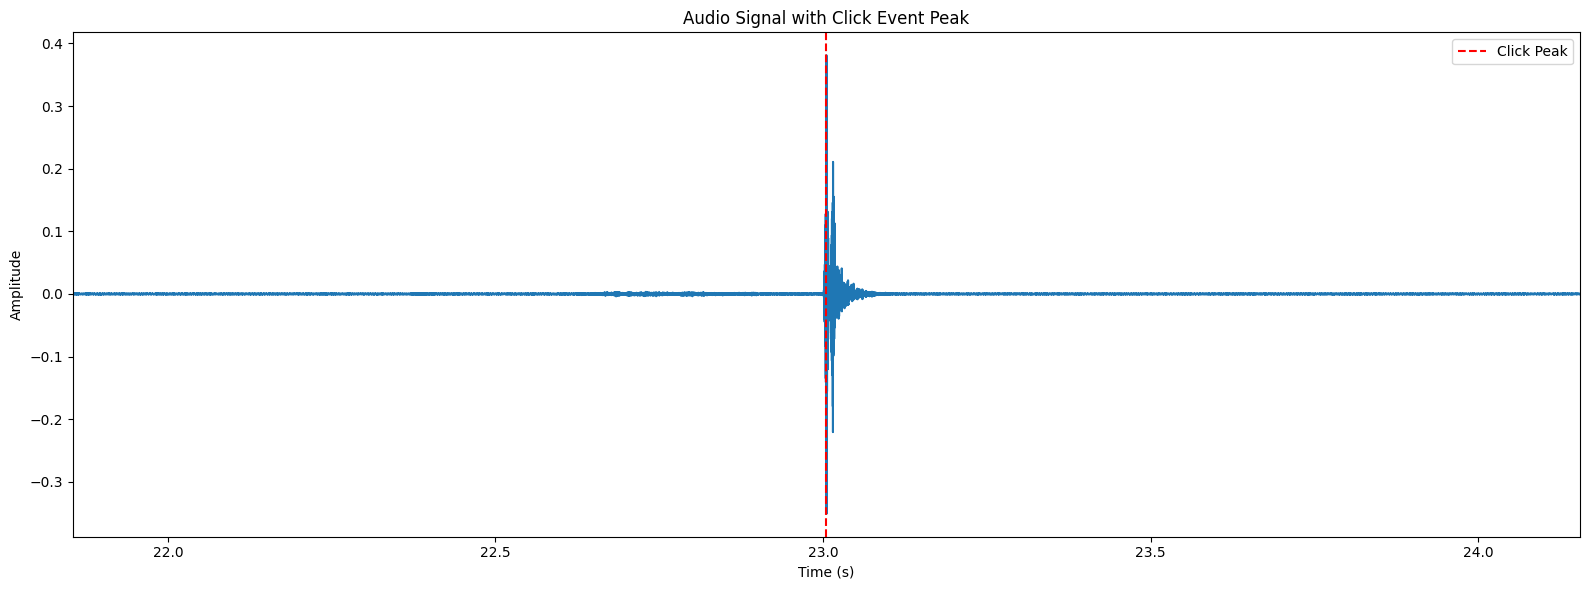

In [37]:
# plot the signal interval around the peak time of the click event for the same audio file in the selected dataset as the spectrogram plot above

signal = signals[file_id_num]
time = signal_times[file_id_num]
peak_time = peak_times[file_id_num]
interval = time_interval//2

plot_signal_interval(signal, time, peak_time, interval)

## 3. Go through each audio data with a sliding window and create the training dataset
In the real-time detection a window of 0.512 seconds will be used for every chunk input at 0.128 seconds. 0.512 seconds covers 4 chunks.

In [38]:
# duration is set to be larger than click events (click events around 0.015s)

window_size_sec = time_interval # 0.512 seconds, corresponds to 4 chunks with 4096 samples each, should be larger than the click event duration!!
window_size = int(window_size_sec / resolution) # spectrogram columns in the window
step_size_sec = 0.128 # in seconds, corresponds to a chunks with 4096 samples --> overlap
step_size = int(step_size_sec / resolution)
print(window_size, step_size)

32 8


11144
11144
240
[176, 177, 178, 179, 420, 421, 422, 423, 603, 604]
-120.0
-6.131253


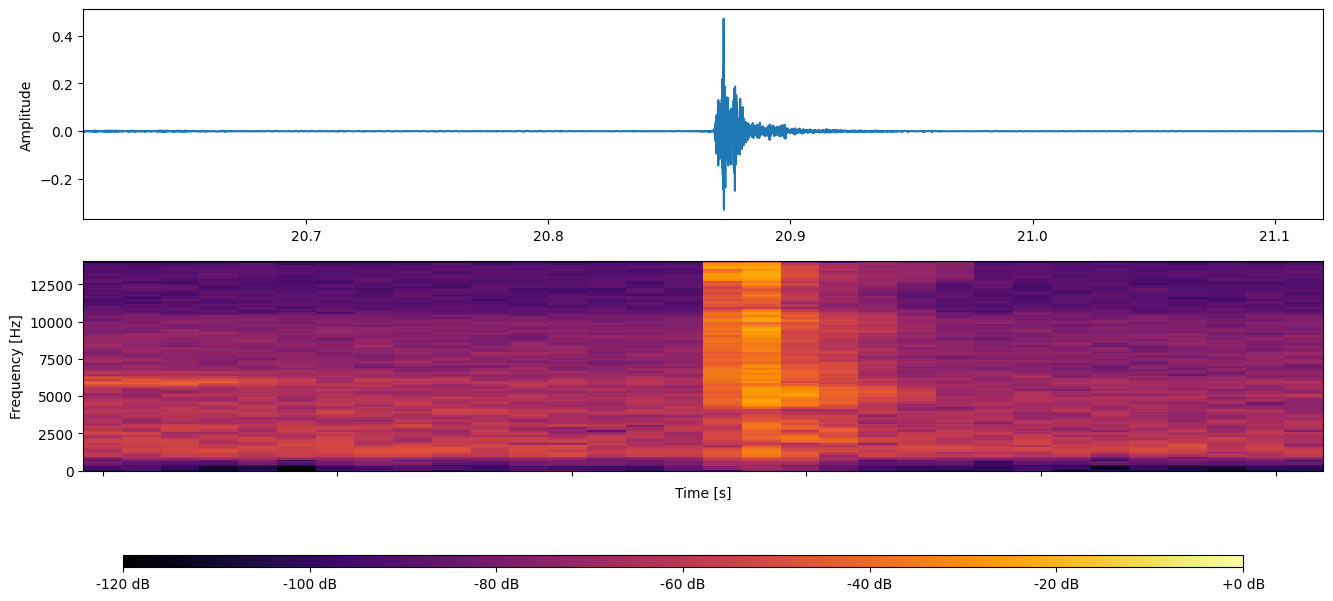

In [42]:
# create spectrogram chunks and corresponding labels for the selected dataset

spec_chunk_dataset = []
spec_chunk_labels = []
signal_chunks = []
time_chunks = []

def createSpectrogramDataset(spectrograms, signals, signal_times, peak_times):
    for i in range(len(spectrograms)):
        spectrogram = spectrograms[i]
        signal = signals[i]
        time = signal_times[i]
        peak_time = peak_times[i]
        peak_time_index = int(peak_time / resolution)

        for start_idx in range(0, spectrogram.shape[1] - window_size, step_size):
            end_idx = start_idx + window_size
            
            spectrogram_chunk = spectrogram[:,start_idx:end_idx]
            signal_chunk = signal[start_idx*hop_length:end_idx*hop_length]
            time_chunk = time[start_idx*hop_length : end_idx*hop_length]
            
            if start_idx <= peak_time_index < end_idx:
                label = 1
            else:
                label = 0

            spec_chunk_dataset.append(spectrogram_chunk)
            spec_chunk_labels.append(label)
            signal_chunks.append(signal_chunk)
            time_chunks.append(time_chunk)

    return spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks

spec_chunk_dataset, spec_chunk_labels, signal_chunks, time_chunks = createSpectrogramDataset(spectrograms, signals, signal_times, peak_times)

print(len(spec_chunk_dataset)) # number of spectrogram chunks
print(len(spec_chunk_labels)) # number of labels
print(spec_chunk_labels.count(1)) # number of chucnks containing click events --> because of the window overlap it is larger than the dataset length
print([i for i, x in enumerate(spec_chunk_labels) if x == 1][:10]) # indices of the chunks containing click events, first 10

print(np.min(spec_chunk_dataset))
print(np.max(spec_chunk_dataset))

chunk_id_to_plot = 421
plot_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], spec_chunk_dataset[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)

## 4. Save the labeled dataset to the same folder as the audio files processed in .npz format

In [43]:
# save the spectrogram dataset and labels in .npz format into the same directory as the audio files

save_directory = audio_dataset_dir
filename = "spec_dataset_ethernet_wo_added_noise.npz"
file_fullpath = os.path.join(save_directory, filename)

spec_chunk_dataset = np.array(spec_chunk_dataset)
spec_chunk_labels = np.array(spec_chunk_labels)

#print(np.min(spec_chunk_dataset), np.max(spec_chunk_dataset))

np.savez(file_fullpath, spec_chunks=spec_chunk_dataset, labels=spec_chunk_labels)



(128, 32)
11144
11144
240


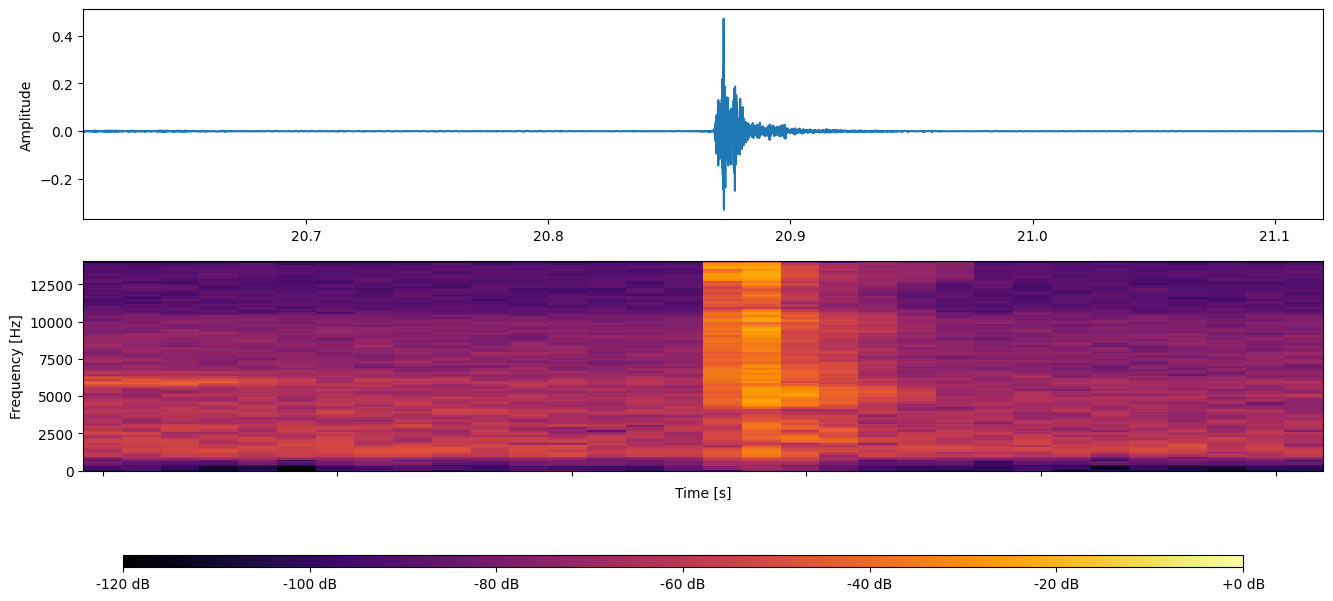

In [44]:
# check if the saved dataset can be loaded

data = np.load(file_fullpath)
loaded_chunks = data['spec_chunks']
loaded_labels = data['labels']

print(loaded_chunks[0].shape)
print(len(loaded_chunks))
print(len(loaded_labels))
# count the number of positive labels in numpy array
print(np.count_nonzero(loaded_labels == 1))

# plot out one spectrogram chunk
plot_mel_spectrogram(signal_chunks[chunk_id_to_plot], time_chunks[chunk_id_to_plot], loaded_chunks[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels, sampling_rate)